First, establish an ssh tunnel [with your PNI password] to jtb3-dev.princeton.edu to make the database available to you:

    ssh username@jtb3-dev.princeton.edu -L 3306:127.0.0.1:3306 -N

jtb3-dev is the database server on which all behavior and mouse data is stored. Second, make sure you have installed datajoint >= '0.12.dev3'
[ pip install datajoint==0.12.dev3 ]

In [3]:
import pylab as pl
import datajoint as dj
import numpy as np
import os
# from flask_login import UserMixin
from flask_bcrypt import Bcrypt
import secrets
assert dj.__version__=='0.12.dev3'

In [8]:
schema = dj.schema('ahoag_lightsheet_demo') # password = 'p@sswd'

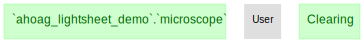

In [9]:
dj.ERD(schema)

In [8]:
schema.drop()

Proceed to delete entire schema `ahoag_lightsheet_demo`? [yes, No]: yes


In [81]:
# schema=dj.create_virtual_module(module_name='lightsheet',schema_name='ahoag_lightsheet_demo',create_schema=True)

In [18]:
@schema
class User(dj.Lookup):
    definition = """
    # Users of the light sheet microscope
    username : varchar(20)      # user in the lab
    ---
    email       : varchar(50)
    """

@schema
class Experiment(dj.Manual):
    definition = """ # Experiments performed using the light sheet microscope
    experiment_id           :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    username                :   varchar(20)
    title                   :   varchar(100)
    description             :   varchar(250)
    notes = ""              :   varchar(1000)
    species                 :   varchar(50)
    clearing_protocol       :   enum("iDISCO+_immuno","iDISCO abbreviated clearing","uDISCO","iDISCO+","iDISCO_EdU")
    clearing_progress       :   enum("incomplete","complete")
    fluorophores            :   varchar(100)
    primary_antibody        :   varchar(100)
    secondary_antibody      :   varchar(100)
    image_resolution        :   enum("1.3x","4x")
    cell_detection          :   tinyint
    registration            :   tinyint
    probe_detection         :   tinyint
    injection_detection     :   tinyint
    """
    
@schema
class Clearing(dj.Manual):
    definition = """ # Experiments performed using the light sheet microscope
    experiment_id           :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    username                :   varchar(20)
    title                   :   varchar(100)
    description             :   varchar(250)
    species                 :   varchar(50)
    clearing_protocol       :   enum("iDISCO+_immuno","iDISCO abbreviated clearing","uDISCO","iDISCO+","iDISCO_EdU")
    clearing_notes = ""     :   varchar(500)
    """



In [17]:
Experiment().drop()

`ahoag_lightsheet_demo`.`experiment` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [19]:
Experiment() #Shows the current content of the database

experiment_id allowed here are sql datatypes.,username,title,description,notes,species,clearing_protocol,clearing_progress,fluorophores,primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,probe_detection,injection_detection


In [20]:
Clearing()

experiment_id allowed here are sql datatypes.,username,title,clearing_protocol,clearing_notes


## 2) Generate content for the database

In [21]:
home_dir = os.environ['HOME']
dj_dir = home_dir + '/Git/lightserv_dj_demo/lightserv/data'
csv_file = dj_dir + '/pni_core_facility_request_responses.txt'
import csv

In [22]:
def fill_user_table():
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        data_dict = {}
        next(reader) # skips the header
        index = 0
        for row in reader:
            email = row[0]
            username = email.split('@')[0].lower()
#             password = row[1]
#             hashed_password = bcrypt.generate_password_hash(password).decode('utf-8')
            insert_user_list = [username,email]
#             print(insert_user_list)
            User().insert((insert_user_list,),skip_duplicates = True)
            index+=1

column_names = ['username','title','description','notes','species','clearing_protocol',
                'clearing_progress','fluorophores','primary_antibody','secondary_antibody',
                'image_resolution','cell_detection','registration',
                'probe_detection','injection_detection']
def fill_exp_table():
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        data_dict = {}
        next(reader) # skips the header
        index = 0
        for row in reader:
            email = row[0]
            username = email.split('@')[0].lower()
#             insert_exp_list = [username,index] + row[2:]  
            insert_exp_list = [username] + row[3:]
#             print(insert_exp_list)
            insert_dict = {column_names[ii]:insert_exp_list[ii] for ii in range(len(column_names))}
            Experiment().insert1(insert_dict,skip_duplicates=True)
            index+=1
    #     response_dict = {rows[0]:rows[1] for rows in reader}
    # print(keys)

In [23]:
fill_user_table()

In [24]:
User()

username user in the lab,email
ahoag,ahoag@princeton.edu


In [25]:
fill_exp_table()

In [26]:
Experiment()

experiment_id allowed here are sql datatypes.,username,title,description,notes,species,clearing_protocol,clearing_progress,fluorophores,primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,probe_detection,injection_detection
1,ahoag,20190507_Wanglab_exp,Image c-fos in whole brains at 1.3x.,,mouse,iDISCO+,incomplete,None,Anti cfos 1:1000,Donkey antirabbit AF647,1.3x,1,0,0,0
2,ahoag,20190304_LW_m340,Detect placement of optical fiber tip,,mouse,iDISCO abbreviated clearing,incomplete,GCampxDat-Cre Double Transgentic Mouse,None,None,1.3x,0,0,1,0
3,ahoag,201905_atlas00x where x=1:n,"Brody lab rat atlas, iDisco + 1.3x",,rat,iDISCO abbreviated clearing,incomplete,None,None,None,1.3x,0,0,0,0
4,ahoag,an1-31,Recover mcherry expression in cerebellum. Morphology analysis.,,mouse,iDISCO+,incomplete,mcherry,rabbit anti-RFP 1:1000,Donkey antiRabbit 647 1:450,1.3x,0,0,0,1


In [27]:
contents=Experiment() & 'species="rat"'
contents

experiment_id allowed here are sql datatypes.,username,title,description,notes,species,clearing_protocol,clearing_progress,fluorophores,primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,probe_detection,injection_detection
3,ahoag,201905_atlas00x where x=1:n,"Brody lab rat atlas, iDisco + 1.3x",,rat,iDISCO abbreviated clearing,incomplete,None,None,None,1.3x,0,0,0,0


In [83]:
insert_dict = {'experiment_id':3,'username': 'testuser', 'title': '201905_atlas00x where x=1:n', 'description': 'Brody lab rat atlas, iDisco + 1.3x', 'notes': 'Some notes', 'species': 'rat', 'clearing_protocol': 'iDISCO abbreviated clearing', 'fluorophores': 'None', 'primary_antibody': 'None', 'secondary_antibody': 'None', 'image_resolution': '1.3x', 'cell_detection': '0', 'registration': '0', 'probe_detection': '0', 'injection_detection': '0'}

In [22]:
contents.fetch1('notes')

''

In [91]:
Experiment().insert1(insert_dict)

DuplicateError: Duplicate entry '3' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [85]:
Experiment()

experiment_id allowed here are sql datatypes.,username,title,description,notes,species,clearing_protocol,fluorophores,primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,probe_detection,injection_detection
1,ahoag,20190507_Wanglab_exp,Image c-fos in whole brains at 1.3x.,,mouse,iDISCO+,None,Anti cfos 1:1000,Donkey antirabbit AF647,1.3x,1,0,0,0
2,ahoag,20190304_LW_m340,Detect placement of optical fiber tip,,mouse,iDISCO abbreviated clearing,GCampxDat-Cre Double Transgentic Mouse,None,None,1.3x,0,0,1,0
3,testuser,201905_atlas00x where x=1:n,"Brody lab rat atlas, iDisco + 1.3x",Some notes,rat,iDISCO abbreviated clearing,None,None,None,1.3x,0,0,0,0
4,ahoag,an1-31,Recover mcherry expression in cerebellum. Morphology analysis.,,mouse,iDISCO+,mcherry,rabbit anti-RFP 1:1000,Donkey antiRabbit 647 1:450,1.3x,0,0,0,1


In [74]:
Experiment().fetch("KEY")

[{'experiment_id': 1},
 {'experiment_id': 2},
 {'experiment_id': 3},
 {'experiment_id': 4}]

In [56]:
# (Experiment() & 'experiment_id > 0').delete_quick()

In [61]:
# Experiment().drop_quick()

In [68]:
len(Experiment())

4

In [74]:
schema.drop(force=True)

In [ ]:
test_schema = dj.schema('ahoag_test')

In [33]:
test_schema = dj.schema('ahoag_lightsheet_test')

In [46]:
test_schema.schema.drop(force=True)

In [75]:
dj.get_schema_names()

['ahoag_lightsheet_demo',
 'pni_acquisition',
 'pni_action',
 'pni_lab',
 'pni_microscope',
 'pni_reference',
 'pni_subject',
 'pni_task',
 'test_lightsheet']

In [41]:
test_schema.drop(force=True)

In [55]:
dj.get_schema_names()

['ahoag_lightsheet_demo',
 'ahoag_lightsheet_test',
 'pni_acquisition',
 'pni_action',
 'pni_lab',
 'pni_microscope',
 'pni_reference',
 'pni_subject',
 'pni_task',
 'test_lightsheet']

In [50]:
test_schema = dj.create_virtual_module('test','ahoag_lightsheet_test',create_schema=True,create_tables=True)

In [53]:
@test_schema.schema
class User(dj.Lookup):
    definition = """
    # Users of the light sheet microscope
    username : varchar(20)      # user in the lab
    ---
    email       : varchar(50)
    password    : varchar(100)
    """

In [57]:
new_schema = dj.create_virtual_module('test','ahoag_lightsheet_test')